In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import seaborn as sns
import netCDF4
from glob import glob 
import cmocean
from xgcm import Grid
import momlevel

import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
sns.set_style('white')
sns.set_context('paper', font_scale=3)
sns.set_palette('hls', 4)
sns.set_style('ticks')

In [3]:
# static file 
fname_static = "/net/smg/OWG/CM4_highres/grids/p125/ocean_annual.static.nc"
static       = xr.open_mfdataset(fname_static)
areacello    = static['areacello']
Coriolis     = static['Coriolis']

In [4]:
# create a grid using xgcm 

coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
}
     
metrics = {
    'X': ["dxt", "dxCu", "dxCv"],
    'Y': ["dyt", "dyCu", "dyCv"]
}

grid = Grid(static, coords=coords, metrics=metrics, periodic=['X'])

In [5]:
# get Coriolis onto xh and yh grid 
fcoriolisA = grid.interp(Coriolis,   'Y', boundary='extend')
fcoriolisB = grid.interp(fcoriolisA, 'X', boundary='extend')
fcoriolis  = np.abs(fcoriolisB)
grav=980 

In [7]:
# dataset

dir    = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_z/av/annual_10yr"
files  = glob(f"{dir}/ocean_annual_z.1930-1939.ann.nc")
files += glob(f"{dir}/ocean_annual_z.1940-1949.ann.nc")
files += glob(f"{dir}/ocean_annual_z.1950-1959.ann.nc")

ds = xr.open_mfdataset(files)
ds = ds.drop_dims('nv')

for coord in ["xh", "yh", "xq", "yq"]:
    static[coord] = ds[coord]
    
ds = ds.assign_coords({'geolon_u': static['geolon_u'],
                       'geolat_u': static['geolat_u'],
                       'geolon_v': static['geolon_v'],
                       'geolat_v': static['geolat_v'],
                       'geolon'  : static['geolon'],
                       'geolat'  : static['geolat']
                       })

N2       = ds['obvfsq'].mean(dim='time')
volcello = ds['volcello'].mean(dim='time')
thkcello = volcello/areacello
fN2      = N2 * fcoriolis 

z_i = ds['z_i'].values
z_l = ds['z_l'].values
xh  = ds['xh'].values
yh  = ds['yh'].values

fN2.load()
thkcello.load()

<xarray.DataArray (z_l: 35, yh: 2240, xh: 2880)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 -298.6 -298.5 -298.4 -298.3 ... 61.05 61.16 61.28
  * yh       (yh) float64 -83.62 -83.58 -83.54 -83.5 ... 89.81 89.86 89.92 89.97
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    geolon   (yh, xh) float32 -298.6 -298.5 -298.4 -298.2 ... 60.0 60.0 60.0
    geolat   (yh, xh) float32 -82.46 -82.46 -82.45 -82.45 ... 64.17 64.11 64.06

In [8]:
# cumsum to get the depth at the base of a cell
zdepth_zl = thkcello.cumsum(dim='z_l')

# zdepth is really defined at the cell interfaces, though 
# the cumsum operator does not move its location so it is still
# dimensioned with z_l. So we need to do the move by brute force.
# I wish therr was an xgcm feature to do the vertical interpolation.  

# first need to cat a zero array onto the 0th position of zdepth 
zero_array = xr.zeros_like(areacello)
zero_array = zero_array.expand_dims({'z_l': [0]})
zdepth     = xr.concat([zero_array, zdepth_zl], dim='z_l')

# now define an xarray dataset with zdepth values and named "depth" 
depth_coord = xr.Dataset(
    data_vars={'depth': (['z_i', 'yh', 'xh'], zdepth.values)},
    coords={'z_i': z_i, 'yh': yh, 'xh': xh}
)

# now add "depth" to fN2 with values from depth_coord dataset
fN2_with_depth = fN2.assign_coords(depth=depth_coord['depth'])

In [9]:
# compute the zonal mean using the naive method from python.
# note that all dimensions that depend on xh will be dropped. 

zdepth_xmean      = zdepth.mean(dim='xh')
fN2_with_depth_xm = fN2_with_depth.mean(dim='xh')


# now define an xarray dataset with zdepth values and named "depth" 
depth_coord_xmean = xr.Dataset(
    data_vars={'depth_xmean': (['z_i', 'yh'], zdepth_xmean.values)},
    coords={'z_i': z_i, 'yh': yh}
)

fN2_with_depth_xmean = fN2_with_depth_xm.assign_coords(depth=depth_coord_xmean['depth_xmean'])

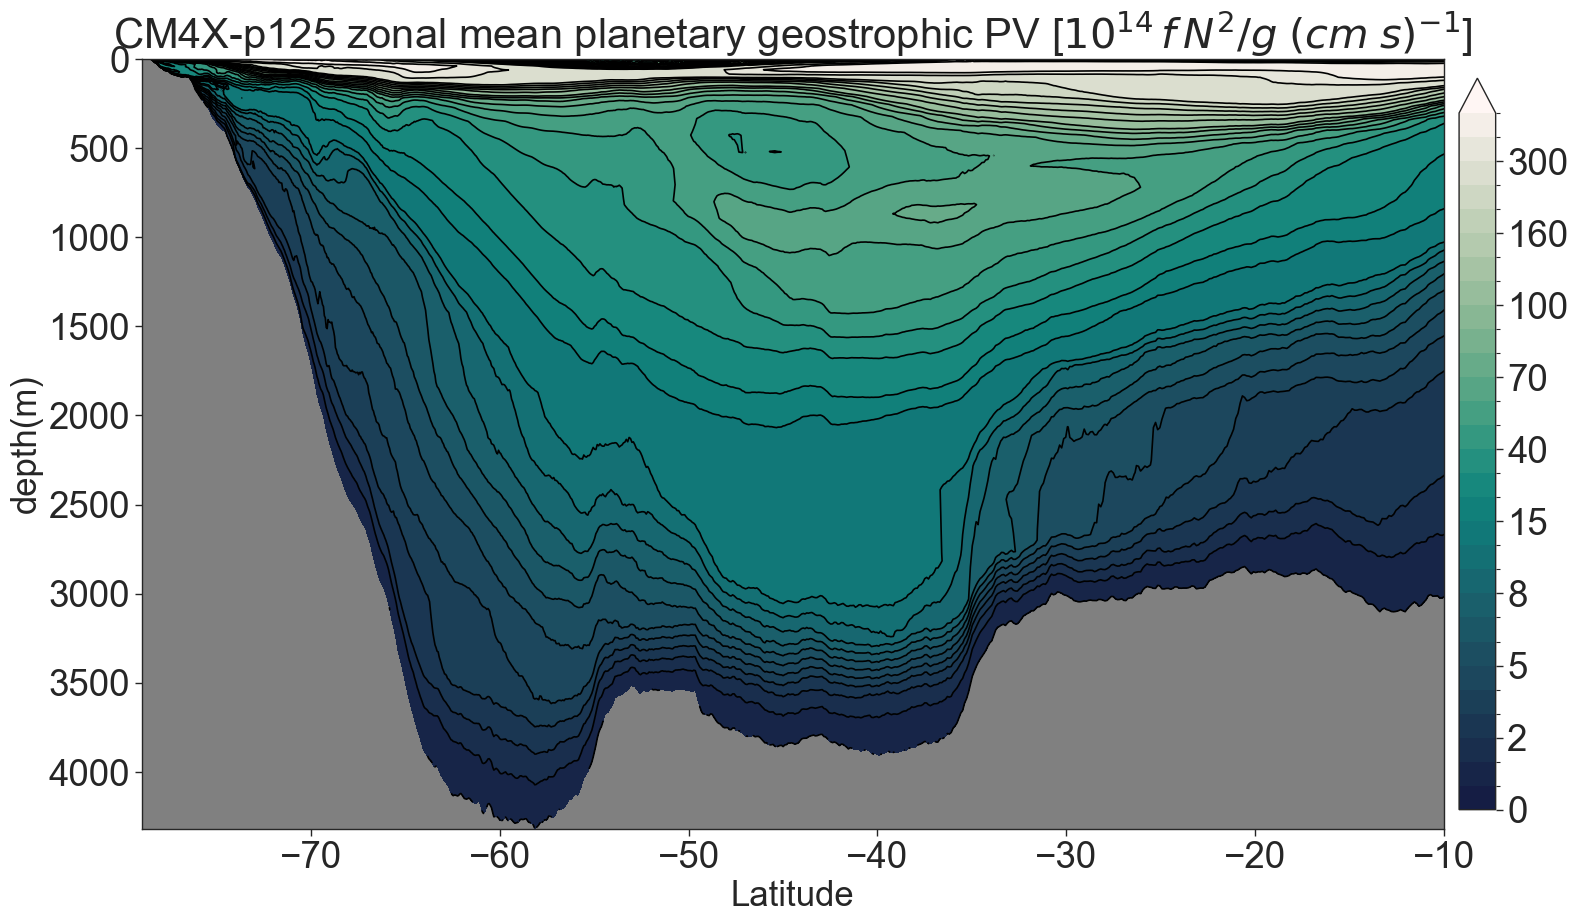

In [10]:
# meridional-z zonal mean slice 

fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
scale  = 1e14/grav
field  = fN2_with_depth_xmean * scale 
#levels = np.arange(0,2.1,0.1)
levels, colors = momlevel.util.get_pv_colormap()


p=xr.plot.contourf(field, ax=axis, 
                   x='yh',y='depth',
                   levels=levels, 
#                  colors=colors,
#                   cmap='RdBu_r',
                   cmap=cmocean.cm.tempo_r,
                   add_colorbar=False
            )

pp=xr.plot.contour(field, ax=axis, 
                   x='yh',y='depth',
                   levels=levels,
                   colors='k'
            )


#plt.ylim((0,5000))
plt.xlim((-79,-10))
#plt.ylim((0,20))
plt.gca().invert_yaxis()
axis.set_ylabel("depth(m)",fontsize=25)
axis.set_xlabel("Latitude",fontsize=25)
axis.set_facecolor('gray')
axis.set_title("CM4X-p125 zonal mean planetary geostrophic PV [$10^{14} \, f \, N^{2}/g$ $(cm \; s)^{-1}$]",fontsize=30)
cbar = plt.colorbar(p,pad=0.01,spacing='uniform', extend='both', 
                    shrink=0.95,orientation='vertical')
#cbar.set_ticks(clevels)

plt.show()
fig.savefig('CM4Xp125_fN2_xmean.png', bbox_inches='tight', dpi=200)

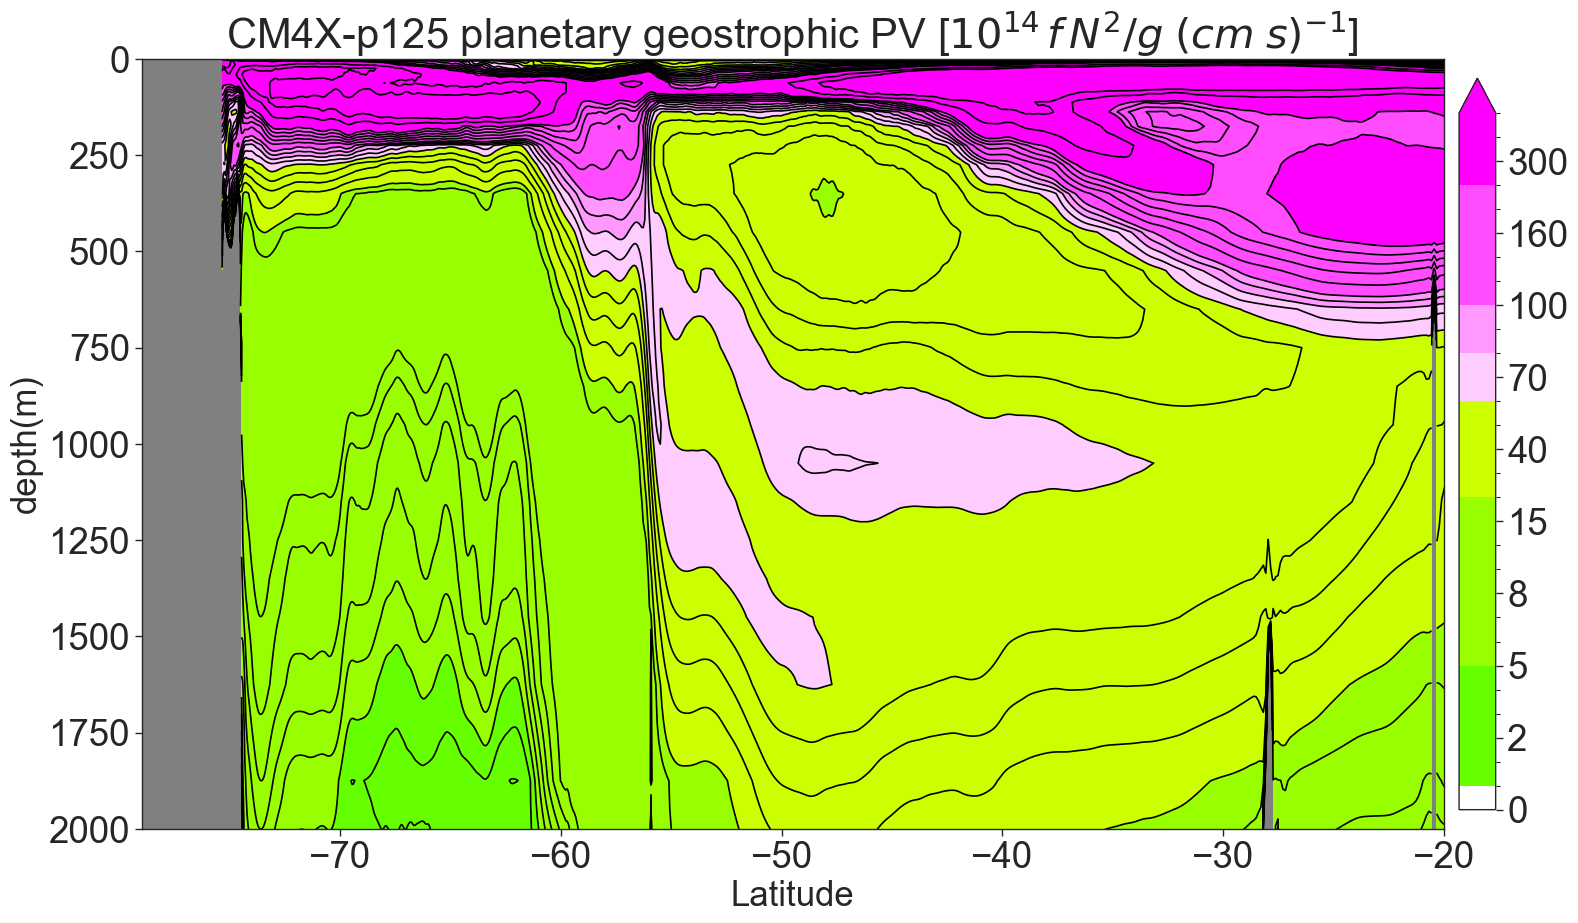

In [14]:
# meridional-z slice 

fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
scale  = 1e14/grav
field  = fN2_with_depth.sel(xh=-150, method='nearest') * scale 
levels = np.arange(0,2.1,0.1)
levels, colors = momlevel.util.get_pv_colormap()


p=xr.plot.contourf(field, ax=axis, 
                   x='geolat',y='depth',
#                   x='geolat',y='z_i',
                   levels=levels, 
                   colors=colors,
#                   cmap='RdBu_r',
#                   cmap=cmocean.cm.tempo_r,
                   add_colorbar=False
            )

pp=xr.plot.contour(field, ax=axis, 
                   x='yh',y='depth',
                   levels=levels,
                   colors='k'
            )


#plt.ylim((0,5000))
plt.xlim((-79,-20))
plt.ylim((0,2000))
plt.gca().invert_yaxis()
axis.set_ylabel("depth(m)",fontsize=25)
axis.set_xlabel("Latitude",fontsize=25)
axis.set_facecolor('gray')
axis.set_title("CM4X-p125 planetary geostrophic PV [$10^{14} \, f \, N^{2}/g$ $(cm \; s)^{-1}$]",fontsize=30)
cbar = plt.colorbar(p,pad=0.01,spacing='uniform', extend='both', 
                    shrink=0.95,orientation='vertical')
#cbar.set_ticks(clevels)

plt.show()
fig.savefig('CM4Xp125_fN2.png', bbox_inches='tight', dpi=200)